In [13]:
# Toilet Hygiene Forecasting with CNN + LSTM
# ============================
# STEP 1: DATA PREPROCESSING
# ============================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import streamlit as st

# Load and clean dataset
try:
    df = pd.read_csv("merged_cleaned_dataset.csv")
    df = df.dropna()
    
    # Fix timestamp parsing (day/month/year format)
    df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
    df = df.sort_values('timestamp')
    
    # Verify data
    print(f"Dataset loaded with shape: {df.shape}")
    print("Sample data:")
    print(df.head())
    
except Exception as e:
    raise ValueError(f"Data loading failed: {str(e)}")

features = ['ammonia', 'humidity', 'temperature', 'iaq', 'co2']
data = df[features].copy()

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create time-series sequences
def create_sequences(data, input_steps=30, output_steps=60):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30, 60)

# Verify sequences were created
if len(X) == 0:
    raise ValueError("No sequences created. Possible causes:\n"
                   "- Dataset too small\n"
                   "- Reduce input_steps/output_steps parameters")

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")

# ============================
# STEP 2: MODELING (CNN + LSTM)
# ============================
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', 
          input_shape=(30, 5)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(60 * 5)  # output: 60 time steps * 5 features
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, 
    y_train.reshape((y_train.shape[0], -1)),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Save model here
model.save("cnn_lstm_forecast_1hour.h5")
print("✅ Model saved successfully.")


# ============================
# STEP 3: PERFORMANCE METRICS
# ============================
y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape((y_pred.shape[0], 60, 5))

# Calculate metrics
mae = mean_absolute_error(y_test.reshape(-1, 5), y_pred_reshaped.reshape(-1, 5))
mse = mean_squared_error(y_test.reshape(-1, 5), y_pred_reshaped.reshape(-1, 5))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.reshape(-1, 5), y_pred_reshaped.reshape(-1, 5))



print("\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# ============================
# STEP 4: STREAMLIT DASHBOARD
# ============================
def run_streamlit_app():
    st.title("Toilet Hygiene Forecast (Next 1 Hour)")
    
    # Get most recent 30 timesteps
    input_window = data_scaled[-30:]
    input_window = input_window.reshape(1, 30, 5)
    
    # Make prediction
    prediction = model.predict(input_window).reshape(60, 5)
    prediction_df = pd.DataFrame(scaler.inverse_transform(prediction), 
                               columns=features)
    
    # Display results
    st.subheader("Predicted Values (Next 60 Minutes)")
    st.line_chart(prediction_df)
    
    st.dataframe(prediction_df)

    # Rule-based status
    latest_pred = prediction_df.iloc[-1]
    if (latest_pred['ammonia'] > 5 and 
        latest_pred['humidity'] > 80 and 
        latest_pred['temperature'] > 26):
        st.warning("🚨 Predicted Toilet Status: DIRTY")
    else:
        st.success("✅ Predicted Toilet Status: CLEAN")

# Uncomment to run Streamlit
# if __name__ == '__main__':
#     run_streamlit_app()

Dataset loaded with shape: (256047, 6)
Sample data:
                 timestamp  ammonia  humidity  temperature   iaq         co2
120056 2024-01-02 08:00:00     0.60     51.98        33.53  25.0  444.380574
120057 2024-01-02 08:10:00     0.62     51.53        33.50  25.0  660.025458
120058 2024-01-02 08:20:00     0.69     50.50        33.36  25.0  730.562588
120059 2024-01-02 08:30:00     0.70     53.35        32.18  25.0  446.682289
120060 2024-01-02 08:40:00     0.72     53.70        31.77  25.0  426.741106
Training sequences: 204765
Test sequences: 51192


C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 91s 30ms/step - loss: 0.0302 - val_loss: 0.0200
Epoch 2/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 140s 29ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 3/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 137s 27ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 4/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 0.0222 - val_loss: 0.0198
Epoch 5/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 85s 29ms/step - loss: 0.0222 - val_loss: 0.0198
Epoch 6/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.0221 - val_loss: 0.0198
Epoch 7/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch 8/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch 9/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 0.0221 - val_loss: 0.0198
Epoch 10/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch 11/20
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 140s 30ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch

✅ Model saved successfully.
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step

Model Performance:
MAE: 0.0727
RMSE: 0.1379
R2 Score: -808202116816349440.0000


In [14]:
y_true = y_test.reshape(-1, 5)
y_pred = y_pred_reshaped.reshape(-1, 5)

# Periksa NaN
print("NaN in y_true:", np.isnan(y_true).sum())
print("NaN in y_pred:", np.isnan(y_pred).sum())

# Buang NaN kalau perlu
mask = ~np.isnan(y_true).any(axis=1) & ~np.isnan(y_pred).any(axis=1)
y_true = y_true[mask]
y_pred = y_pred[mask]



NaN in y_true: 0
NaN in y_pred: 0


In [15]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


MAE: 0.0727
RMSE: 0.1379
R2: -808202116816349440.0000


In [17]:
# Reshape
y_true = y_test.reshape(-1, 5)
y_pred = y_pred_reshaped.reshape(-1, 5)

# Inverse transform
y_true_inv = scaler.inverse_transform(y_true)
y_pred_inv = scaler.inverse_transform(y_pred)

# Metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")


MAE: 21.65
RMSE: 51.86
R2 Score: 0.3900


In [11]:
# ============================
# STEP: SAVE TRAINED MODEL
# ============================
# Save model ke dalam format .h5
model.save("cnn_lstm_forecast_1hour.h5")
print("✅ Model saved successfully as cnn_lstm_forecast_1hour.h5")


✅ Model saved successfully as cnn_lstm_forecast_1hour.h5


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load data & scaler
df = pd.read_csv("merged_cleaned_dataset.csv")
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values('timestamp')
features = ['ammonia', 'humidity', 'temperature', 'iaq', 'co2']
data = df[features].copy()

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Recreate sequences
def create_sequences(data, input_steps=30, output_steps=60):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30, 60)

# Split
split = int(0.8 * len(X))
X_test = X[split:]
y_test = y[split:]

# Load trained model
model = load_model("cnn_lstm_forecast_1hour.h5", compile=False)

# Predict
y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape((-1, 5))
y_true = y_test.reshape((-1, 5))

# Inverse transform
y_true_inv = scaler.inverse_transform(y_true)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

# Regression metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

#  classification hygiene level
def classify(ammonia, humidity, temp):
    if ammonia > 4 and humidity > 60 and temp > 32:
        return "High Hygiene Risk"
    elif ammonia > 2 and humidity > 50 and temp > 30:
        return "Medium Hygiene Risk"
    else:
        return "Low Hygiene Risk"



y_true_labels = [classify(row[0], row[1], row[2]) for row in y_true_inv]
y_pred_labels = [classify(row[0], row[1], row[2]) for row in y_pred_inv]


# Classification metrics
print(confusion_matrix(y_true_labels, y_pred_labels, labels=["Low Hygiene Risk", "Medium Hygiene Risk", "High Hygiene Risk"]))
print(classification_report(y_true_labels, y_pred_labels))


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step
MAE: 21.65
RMSE: 51.86
R2 Score: 0.3900
[[3071520       0       0]
 [      0       0       0]
 [      0       0       0]]
                  precision    recall  f1-score   support

Low Hygiene Risk       1.00      1.00      1.00   3071520

        accuracy                           1.00   3071520
       macro avg       1.00      1.00      1.00   3071520
    weighted avg       1.00      1.00      1.00   3071520



In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

# Load dataset
df = pd.read_csv("merged_cleaned_dataset.csv")
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values('timestamp')
features = ['ammonia', 'humidity', 'temperature', 'iaq', 'co2']
data = df[features].copy()

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, input_steps=30, output_steps=60):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30, 60)
split = int(0.8 * len(X))
X_test = X[split:]
y_test = y[split:]

# Load model
model = load_model("cnn_lstm_forecast_1hour.h5", compile=False)

# Predict
y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape((-1, 5))
y_true = y_test.reshape((-1, 5))

# Inverse transform
y_true_inv = scaler.inverse_transform(y_true)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

# Regression metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Hygiene classification logic (3 classes)
def classify(ammonia, humidity, temp):
    if ammonia > 3 and humidity > 75 and temp > 31:
        return "High Hygiene Risk"
    elif ammonia > 1.5 and humidity > 65 and temp > 29:
        return "Medium Hygiene Risk"
    else:
        return "Low Hygiene Risk"

        
from collections import Counter
print("True label count:", Counter(y_true_labels))
print("Predicted label count:", Counter(y_pred_labels))

y_true_labels = [classify(row[0], row[1], row[2]) for row in y_true_inv]
y_pred_labels = [classify(row[0], row[1], row[2]) for row in y_pred_inv]

# Classification metrics
labels_order = ["Low Hygiene Risk", "Medium Hygiene Risk", "High Hygiene Risk"]
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels, labels=labels_order))
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=labels_order))


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
MAE: 21.65
RMSE: 51.86
R2 Score: 0.3900

Confusion Matrix:
[[3071520       0       0]
 [      0       0       0]
 [      0       0       0]]

Classification Report:


C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

                     precision    recall  f1-score   support

   Low Hygiene Risk       1.00      1.00      1.00   3071520
Medium Hygiene Risk       0.00      0.00      0.00         0
  High Hygiene Risk       0.00      0.00      0.00         0

           accuracy                           1.00   3071520
          macro avg       0.33      0.33      0.33   3071520
       weighted avg       1.00      1.00      1.00   3071520



C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from collections import Counter
from tensorflow.keras.models import load_model

# Load dataset
df = pd.read_csv("merged_cleaned_dataset.csv")
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values('timestamp')
features = ['ammonia', 'humidity', 'temperature', 'iaq', 'co2']
data = df[features].copy()

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, input_steps=30, output_steps=60):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30, 60)
split = int(0.8 * len(X))
X_test = X[split:]
y_test = y[split:]

# Load model
model = load_model("cnn_lstm_forecast_1hour.h5", compile=False)

# Predict
y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape((-1, 5))
y_true = y_test.reshape((-1, 5))

# Inverse transform
y_true_inv = scaler.inverse_transform(y_true)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

# Regression metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Updated hygiene classification logic (3 classes)
def classify(ammonia, humidity, temp):
    if ammonia > 2 and humidity > 50 and temp > 27:
        return "High Hygiene Risk"
    elif ammonia > 1 and humidity > 50 and temp > 25:
        return "Medium Hygiene Risk"
    else:
        return "Low Hygiene Risk"

y_true_labels = [classify(row[0], row[1], row[2]) for row in y_true_inv]
y_pred_labels = [classify(row[0], row[1], row[2]) for row in y_pred_inv]

# Label counts for debugging
print("\nLabel Distribution (True):", Counter(y_true_labels))
print("Label Distribution (Pred):", Counter(y_pred_labels))

# Classification metrics
labels_order = ["Low Hygiene Risk", "Medium Hygiene Risk", "High Hygiene Risk"]
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels, labels=labels_order))
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=labels_order))


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step
MAE: 21.65
RMSE: 51.86
R2 Score: 0.3900

Label Distribution (True): Counter({'Low Hygiene Risk': 3069240, 'Medium Hygiene Risk': 2280})
Label Distribution (Pred): Counter({'Low Hygiene Risk': 3071520})

Confusion Matrix:
[[3069240       0       0]
 [   2280       0       0]
 [      0       0       0]]

Classification Report:


C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

                     precision    recall  f1-score   support

   Low Hygiene Risk       1.00      1.00      1.00   3069240
Medium Hygiene Risk       0.00      0.00      0.00      2280
  High Hygiene Risk       0.00      0.00      0.00         0

           accuracy                           1.00   3071520
          macro avg       0.33      0.33      0.33   3071520
       weighted avg       1.00      1.00      1.00   3071520



C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from collections import Counter
from tensorflow.keras.models import load_model

# Load dataset
df = pd.read_csv("merged_cleaned_dataset.csv")
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values('timestamp')
features = ['ammonia', 'humidity', 'temperature', 'iaq', 'co2']
data = df[features].copy()

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, input_steps=30, output_steps=60):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30, 60)
split = int(0.8 * len(X))
X_test = X[split:]
y_test = y[split:]

# Load model
model = load_model("cnn_lstm_forecast_1hour.h5", compile=False)

# Predict
y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape((-1, 5))
y_true = y_test.reshape((-1, 5))

# Inverse transform
y_true_inv = scaler.inverse_transform(y_true)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

# Regression metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Updated hygiene classification logic (3 classes)
def classify_ammonia_only(ammonia):
    if ammonia > 2:
        return "High Hygiene Risk"
    elif ammonia > 1:
        return "Medium Hygiene Risk"
    else:
        return "Low Hygiene Risk"

y_true_labels = [classify_ammonia_only(row[0]) for row in y_true_inv]
y_pred_labels = [classify_ammonia_only(row[0]) for row in y_pred_inv]

# Label counts for debugging
print("\nLabel Distribution (True):", Counter(y_true_labels))
print("Label Distribution (Pred):", Counter(y_pred_labels))

# Classification metrics
labels_order = ["Low Hygiene Risk", "Medium Hygiene Risk", "High Hygiene Risk"]
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels, labels=labels_order))
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=labels_order))


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step 
MAE: 21.65
RMSE: 51.86
R2 Score: 0.3900

Label Distribution (True): Counter({'Low Hygiene Risk': 3019080, 'Medium Hygiene Risk': 52440})
Label Distribution (Pred): Counter({'Low Hygiene Risk': 3069306, 'Medium Hygiene Risk': 2214})

Confusion Matrix:
[[3018507     573       0]
 [  50799    1641       0]
 [      0       0       0]]

Classification Report:


C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

                     precision    recall  f1-score   support

   Low Hygiene Risk       0.98      1.00      0.99   3019080
Medium Hygiene Risk       0.74      0.03      0.06     52440
  High Hygiene Risk       0.00      0.00      0.00         0

           accuracy                           0.98   3071520
          macro avg       0.57      0.34      0.35   3071520
       weighted avg       0.98      0.98      0.98   3071520



C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\atinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

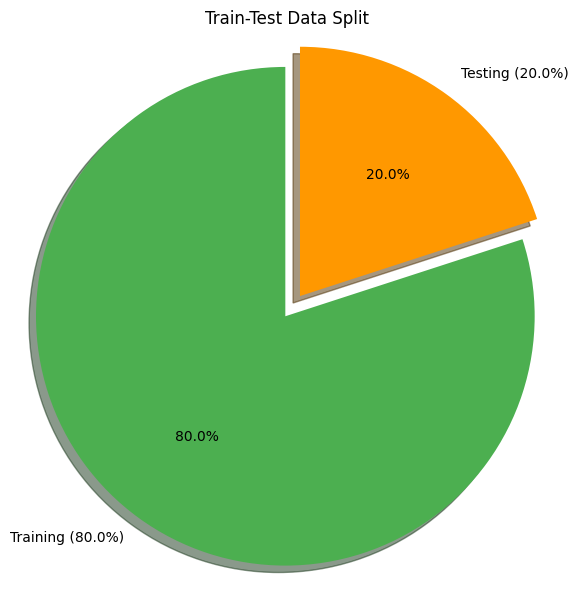

In [2]:
import matplotlib.pyplot as plt

# Values based on your model split
train_count = 204765
test_count = 51192
total = train_count + test_count

# Percentages
train_pct = round(train_count / total * 100, 2)
test_pct = round(test_count / total * 100, 2)

# Pie chart
labels = [f'Training ({train_pct}%)', f'Testing ({test_pct}%)']
sizes = [train_count, test_count]
colors = ['#4CAF50', '#FF9800']
explode = (0.05, 0.05)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=explode, shadow=True)
plt.title('Train-Test Data Split')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.tight_layout()
plt.savefig("data_split_piechart.png")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


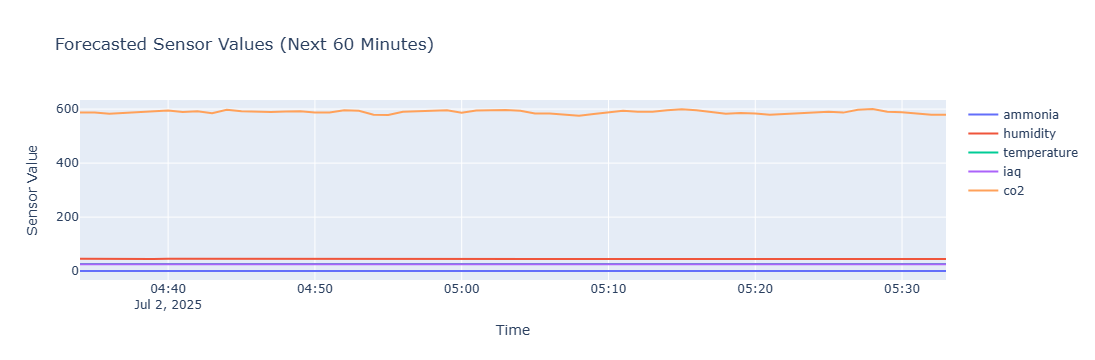

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import plotly.graph_objects as go

# Load your dataset
df = pd.read_csv("merged_cleaned_dataset.csv")
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values('timestamp')

# Prepare input
features = ['ammonia', 'humidity', 'temperature', 'iaq', 'co2']
recent_data = df[features].tail(30)

scaler = MinMaxScaler()
scaled_input = scaler.fit_transform(recent_data)
X_input = scaled_input.reshape(1, 30, 5)

# Load model and predict
model = load_model("cnn_lstm_forecast_1hour.h5", compile=False)
pred = model.predict(X_input).reshape(60, 5)
pred_df = pd.DataFrame(scaler.inverse_transform(pred), columns=features)

# Generate timestamps
now = datetime.datetime.now()
pred_df['timestamp'] = [now + datetime.timedelta(minutes=i+1) for i in range(60)]

# Plot
fig = go.Figure()
for col in features:
    fig.add_trace(go.Scatter(x=pred_df['timestamp'], y=pred_df[col], mode='lines', name=col))
fig.update_layout(title="Forecasted Sensor Values (Next 60 Minutes)", xaxis_title="Time", yaxis_title="Sensor Value")
fig.show()
